<a href="https://colab.research.google.com/github/Sidy3143/Generative-ai/blob/main/linear_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training a simple VAE, using Linear layers

We import the necessary libraries for building and training the VAE, including `torch` for deep learning, `torch.nn` for neural network modules, `torchvision` for the MNIST dataset and transformations, `numpy` for numerical operations, `tqdm` for progress bars, and `matplotlib.pyplot` for plotting.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

This cell loads the MNIST dataset, which consists of handwritten digits. `root='./data'` specifies the directory to store the data, `train=True` indicates that we want the training set, `download=True` downloads the dataset if it's not already present, and `transform=transforms.ToTensor()` converts the images to PyTorch tensors. The `dataloader` is then created to efficiently load the data in batches during training.

In [2]:
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

dataloader = torch.utils.data.DataLoader(dataset=mnist, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.32MB/s]


This cell defines the VAE model as a PyTorch `nn.Module`. It consists of an encoder that maps the input to a latent space (mean and log-variance) and a decoder that reconstructs the input from the latent space. The `encode` method implements the encoder, the `decode` method implements the decoder, and the `forward` method combines them to perform a full pass through the VAE.

In [3]:
class Vae(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Vae, self).__init__()

    # encoder
    self.input2_hid = nn.Linear(input_dim, hidden_dim)
    self.hid2_mu = nn.Linear(hidden_dim, latent_dim)
    self.hid2_sigma = nn.Linear(hidden_dim, latent_dim)

    # decoder
    self.latent2_hid = nn.Linear(latent_dim, hidden_dim)
    self.hid2_input = nn.Linear(hidden_dim, input_dim)

    self.relu = nn.ReLU()

  def encode(self, x):
    hidden = self.relu(self.input2_hid(x))
    mu, log_var = self.hid2_mu(hidden), self.hid2_sigma(hidden)

    return mu, log_var

  def decode(self, z):
    reconstructed = torch.sigmoid(self.hid2_input(self.latent2_hid(z)))

    return reconstructed

  def forward(self, x):
    mu, log_var = self.encode(x)

    sigma = torch.exp(0.5 * log_var)
    epsilon = torch.randn_like(sigma)
    z = mu + sigma * epsilon

    reconstructed = self.decode(z)

    return reconstructed, mu, log_var

In [4]:
input_dim = 784
hidden_dim = 200
latent_dim = 20
lr = 1e-3

model = Vae(input_dim, hidden_dim, latent_dim)
criterion = nn.BCELoss(reduction="sum") # experiment with reduction="sum"
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

In [6]:
model = model.to(device)

In [7]:
# trainning loop
epochs = 20
for i in range(epochs):
  loop = tqdm(enumerate(dataloader))
  for n, (images, _) in loop:
    images = images.reshape(-1, input_dim)
    images = images.to(device)

    reconstructed, mu, log_var = model(images)

    sigma = torch.exp(0.5 * log_var)
    loss = criterion(reconstructed, images)
    kl_div = -torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) # or KL_loss = - Σ (1 + 2*log(σ) - μ² - σ²)
    total_loss = loss + kl_div

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    loop.set_postfix(loss=loss.item())

938it [00:10, 87.80it/s, loss=4.06e+3]
938it [00:10, 93.59it/s, loss=3.67e+3]
938it [00:09, 93.88it/s, loss=3.01e+3]
938it [00:10, 87.18it/s, loss=3.39e+3]
938it [00:10, 92.12it/s, loss=3.4e+3]
938it [00:09, 96.84it/s, loss=3.48e+3]
938it [00:09, 94.40it/s, loss=3.33e+3]
938it [00:10, 92.76it/s, loss=3.58e+3]
938it [00:10, 93.41it/s, loss=3.72e+3]
938it [00:10, 92.99it/s, loss=3.65e+3] 
938it [00:09, 94.09it/s, loss=3.54e+3]
938it [00:09, 96.70it/s, loss=3.39e+3]
938it [00:10, 93.02it/s, loss=3.35e+3]
938it [00:09, 93.91it/s, loss=3.5e+3]
938it [00:09, 93.97it/s, loss=3.58e+3]
938it [00:10, 93.75it/s, loss=3.47e+3]
938it [00:09, 97.78it/s, loss=3.49e+3]
938it [00:09, 94.61it/s, loss=3.44e+3]
938it [00:10, 93.10it/s, loss=3.44e+3] 
938it [00:10, 91.34it/s, loss=3.66e+3]


Let's create a function called `reconstruction` to see how well our VAE can rebuild an image! You give it an image and our trained VAE, and it will show you the original image right next to the VAE's attempt at reconstructing it. We'll send the image through the model to get the reconstruction and then use `matplotlib` to display them side-by-side.

In [8]:
# reconstruction
def reconstruction(image, model):
  with torch.no_grad():
     image = image.view(-1, 28*28)
     image = image.to(device)

     mu, log_var = model.encode(image)
     sigma = torch.exp(0.5 * log_var)

     epsilon = torch.randn_like(sigma)
     z = mu + sigma * epsilon
     reconstructed = model.decode(z)

  img = image.cpu().detach().numpy().reshape(28, 28)
  recon = reconstructed.cpu().detach().numpy().reshape(28, 28)

  plt.figure(figsize=(9, 2))
  plt.subplot(1, 2, 1)
  plt.imshow(img, cmap="gray")
  plt.subplot(1, 2, 2)
  plt.imshow(recon, cmap="gray")
  plt.show()

We'll define a function called `sampling` that lets us generate brand new images! You give it the trained VAE and tell it how many images you want. It will randomly pick points in the latent space, use the VAE's decoder to turn those points into images, and then we'll use `matplotlib` to show off the cool new images it created!

In [9]:
def sampling(model, n_samples=5):
  with torch.no_grad():
    z = torch.randn(n_samples, latent_dim).to(device)

    sampled = model.decode(z)

    sample = sampled.cpu().detach().numpy().reshape(-1, 28, 28)
    for i in range(n_samples):
        plt.imshow(sample[i], cmap="gray")
        plt.show()

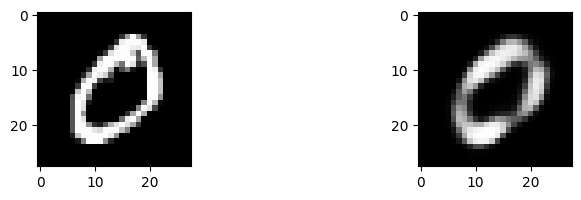

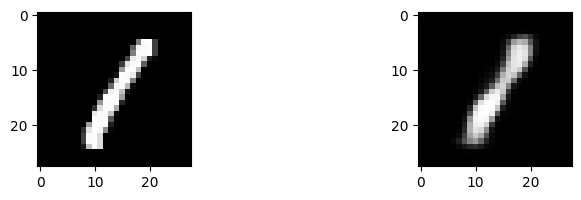

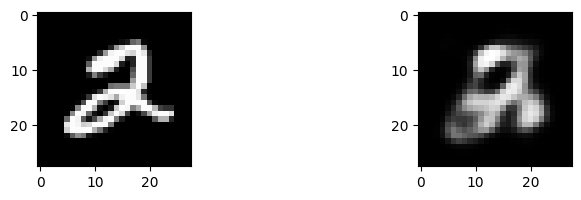

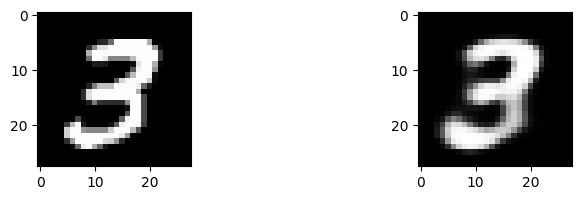

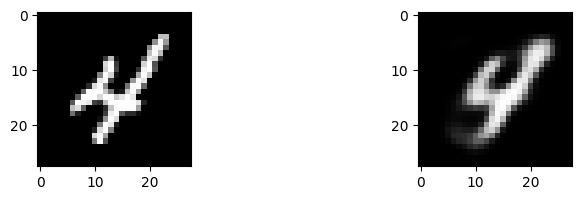

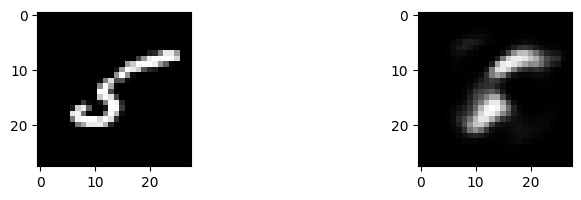

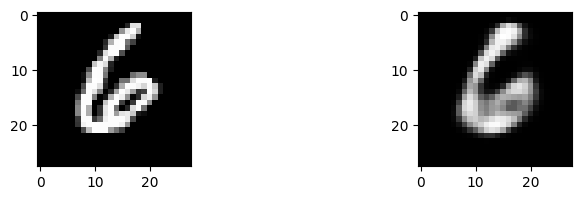

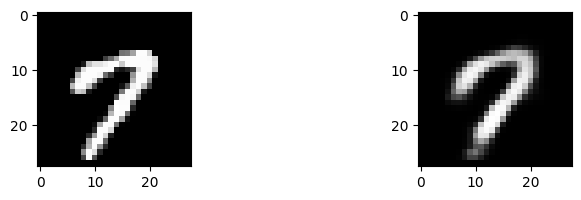

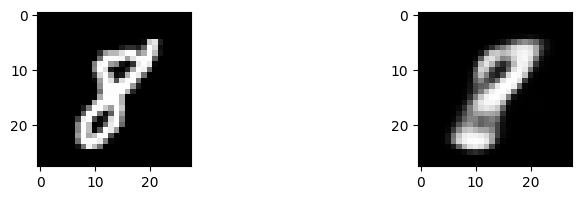

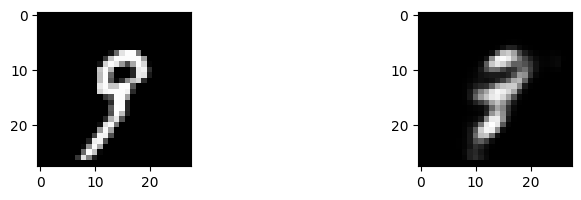

In [10]:
#exemple reconstruction
idx = 0
digits = []
for image, label in mnist:
   if label == idx:
     digits.append(image)
     idx+=1
   if idx==10:
    break

for img in digits:
  reconstruction(img, model)

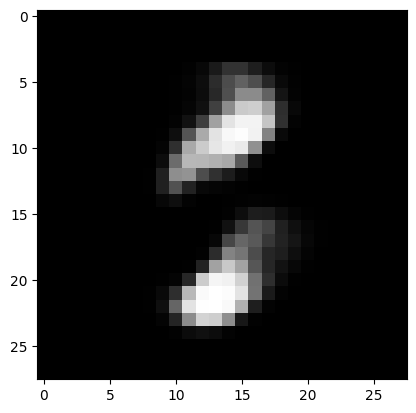

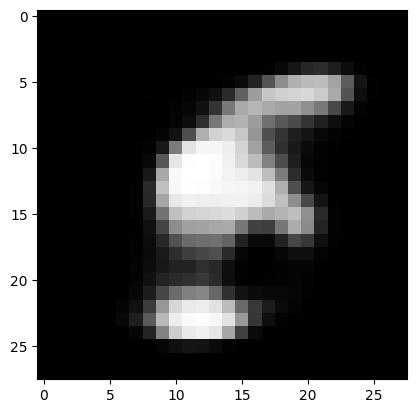

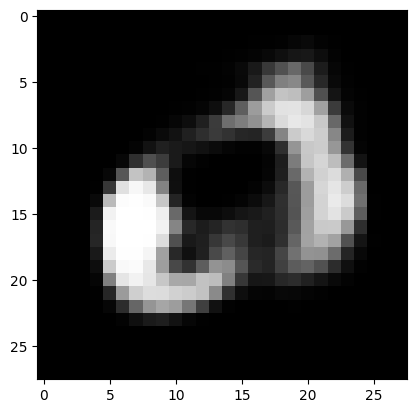

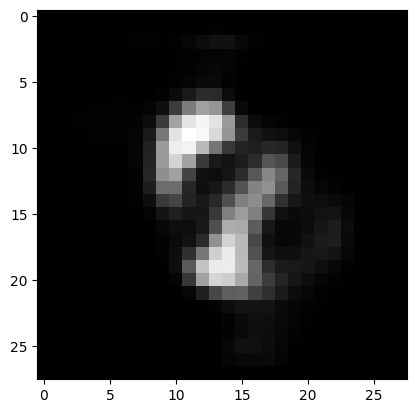

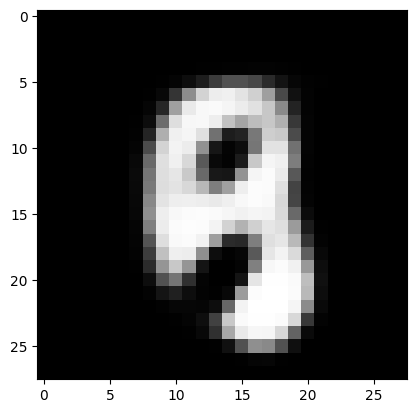

In [11]:
# example sampling

sampling(model)

 Ray Tune is a hyperparameter tuning library that can be used to efficiently search for the best hyperparameters for a machine learning model.

In [12]:
!pip -q install ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 13.2 MB/s eta 0:00:00


In [ ]:
from ray import tune

def train_vae(config):
    model = Vae(input_dim, hidden_dim, latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    dataloader = torch.utils.data.DataLoader(dataset=mnist, batch_size=config["batch_size"], shuffle=True)

    # trainning loop
    epochs = 5
    for i in range(epochs):
      loop = tqdm(enumerate(dataloader))
      for n, (images, _) in loop:
        images = images.reshape(-1, input_dim)
        images = images.to(device)

        reconstructed, mu, log_var = model(images)

        sigma = torch.exp(0.5 * log_var)
        loss = criterion(reconstructed, images)
        kl_div = -torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) # or KL_loss = - Σ (1 + 2*log(σ) - μ² - σ²)
        total_loss = loss + kl_div

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        tune.report({"loss": total_loss.item()})
        if n==20:
          break

config = {
    "lr": tune.grid_search([1e-3, 1e-4, 1e-5]),
    "batch_size": tune.grid_search([32, 64, 128]),
}

analysis = tune.run(
    train_vae,
    config=config,
    # ... (Other Ray Tune configuration options) ...
)

best_config = analysis.get_best_config(metric="loss", mode="min")
print(f"Best hyperparameters: {best_config}")

+------------------------------------------------------------------+
| Configuration for experiment     train_vae_2025-02-11_03-31-05   |
+------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator           |
| Scheduler                        FIFOScheduler                   |
| Number of trials                 9                               |
+------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_vae_2025-02-11_03-31-05
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-02-11_03-21-58_700050_194/artifacts/2025-02-11_03-31-05/train_vae_2025-02-11_03-31-05/driver_artifacts`
(raylet) Warning: The actor ImplicitFunc is very large (90 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.

Trial status: 9 PE

2025-02-11 03:31:24,644	ERROR tune_controller.py:1331 -- Trial task failed for trial train_vae_a0575_00000
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2772, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial train_vae_a0575_00000 errored after 0 iterations at 2025-02-11 03:31:24. Total running time: 18s
Error file: /tmp/ray/session_2025-02-11_03-21-58_700050_194/artifacts/2025-02-11_03-31-05/train_vae_2025-02-11_03-31-05/driver_artifacts/train_vae_a0575_00000_0_batch_size=32,lr=0.0010_2025-02-11_03-31-10/error.txt

Trial train_vae_a0575_00001 errored after 0 iterations at 2025-02-11 03:31:24. Total running time: 18s
Error file: /tmp/ray/session_2025-02-11_03-21-58_700050_194/artifacts/2025-02-11_03-31-05/train_vae_2025-02-11_03-31-05/driver_artifacts/train_vae_a0575_00001_1_batch_size=64,lr=0.0010_2025-02-11_03-31-11/error.txt

Trial train_vae_a0575_00002 started with configuration:
+----------------------------------------------+
| Trial train_vae_a0575_00002 config           |
+----------------------------------------------+
| batch_size                               128 |
| lr                                     0.001 |
+----------------------------------------------+

Trial trai

2025-02-11 03:31:35,788	ERROR tune_controller.py:1331 -- Trial task failed for trial train_vae_a0575_00002
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2772, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial train_vae_a0575_00002 errored after 0 iterations at 2025-02-11 03:31:35. Total running time: 29s
Error file: /tmp/ray/session_2025-02-11_03-21-58_700050_194/artifacts/2025-02-11_03-31-05/train_vae_2025-02-11_03-31-05/driver_artifacts/train_vae_a0575_00002_2_batch_size=128,lr=0.0010_2025-02-11_03-31-11/error.txt

Trial train_vae_a0575_00003 errored after 0 iterations at 2025-02-11 03:31:35. Total running time: 29s
Error file: /tmp/ray/session_2025-02-11_03-21-58_700050_194/artifacts/2025-02-11_03-31-05/train_vae_2025-02-11_03-31-05/driver_artifacts/train_vae_a0575_00003_3_batch_size=32,lr=0.0001_2025-02-11_03-31-12/error.txt

Trial status: 4 ERROR | 5 PENDING
Current time: 2025-02-11 03:31:46. Total running time: 40s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------+
| Trial name              status         lr     batch_size |
+----------------------------------------------------------+
| train_v

2025-02-11 03:31:47,881	ERROR tune_controller.py:1331 -- Trial task failed for trial train_vae_a0575_00004
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2772, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial train_vae_a0575_00004 errored after 0 iterations at 2025-02-11 03:31:47. Total running time: 41s
Error file: /tmp/ray/session_2025-02-11_03-21-58_700050_194/artifacts/2025-02-11_03-31-05/train_vae_2025-02-11_03-31-05/driver_artifacts/train_vae_a0575_00004_4_batch_size=64,lr=0.0001_2025-02-11_03-31-12/error.txt

Trial train_vae_a0575_00005 errored after 0 iterations at 2025-02-11 03:31:48. Total running time: 41s
Error file: /tmp/ray/session_2025-02-11_03-21-58_700050_194/artifacts/2025-02-11_03-31-05/train_vae_2025-02-11_03-31-05/driver_artifacts/train_vae_a0575_00005_5_batch_size=128,lr=0.0001_2025-02-11_03-31-12/error.txt

Trial train_vae_a0575_00007 started with configuration:
+----------------------------------------------+
| Trial train_vae_a0575_00007 config           |
+----------------------------------------------+
| batch_size                                64 |
| lr                                     1e-05 |
+----------------------------------------------+

Trial tra

2025-02-11 03:31:58,752	ERROR tune_controller.py:1331 -- Trial task failed for trial train_vae_a0575_00007
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2772, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial train_vae_a0575_00007 errored after 0 iterations at 2025-02-11 03:31:58. Total running time: 52s
Error file: /tmp/ray/session_2025-02-11_03-21-58_700050_194/artifacts/2025-02-11_03-31-05/train_vae_2025-02-11_03-31-05/driver_artifacts/train_vae_a0575_00007_7_batch_size=64,lr=0.0000_2025-02-11_03-31-13/error.txt

Trial train_vae_a0575_00006 errored after 0 iterations at 2025-02-11 03:31:58. Total running time: 52s
Error file: /tmp/ray/session_2025-02-11_03-21-58_700050_194/artifacts/2025-02-11_03-31-05/train_vae_2025-02-11_03-31-05/driver_artifacts/train_vae_a0575_00006_6_batch_size=32,lr=0.0000_2025-02-11_03-31-13/error.txt

Trial train_vae_a0575_00008 started with configuration:
+----------------------------------------------+
| Trial train_vae_a0575_00008 config           |
+----------------------------------------------+
| batch_size                               128 |
| lr                                     1e-05 |
+----------------------------------------------+


2025-02-11 03:32:05,167	ERROR tune_controller.py:1331 -- Trial task failed for trial train_vae_a0575_00008
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2772, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial train_vae_a0575_00008 errored after 0 iterations at 2025-02-11 03:32:05. Total running time: 58s
Error file: /tmp/ray/session_2025-02-11_03-21-58_700050_194/artifacts/2025-02-11_03-31-05/train_vae_2025-02-11_03-31-05/driver_artifacts/train_vae_a0575_00008_8_batch_size=128,lr=0.0000_2025-02-11_03-31-14/error.txt

Trial status: 9 ERROR
Current time: 2025-02-11 03:32:05. Total running time: 58s
Logical resource usage: 1.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------+
| Trial name              status         lr     batch_size |
+----------------------------------------------------------+
| train_vae_a0575_00000   ERROR      0.001              32 |
| train_vae_a0575_00001   ERROR      0.001              64 |
| train_vae_a0575_00002   ERROR      0.001             128 |
| train_vae_a0575_00003   ERROR      0.0001             32 |
| train_vae_a0575_00004   ERROR      0.0001             64 |
| train_vae_a0575_00005   ERROR    

TuneError: ('Trials did not complete', [train_vae_a0575_00000, train_vae_a0575_00001, train_vae_a0575_00002, train_vae_a0575_00003, train_vae_a0575_00004, train_vae_a0575_00005, train_vae_a0575_00006, train_vae_a0575_00007, train_vae_a0575_00008])